In [1]:
import time
import pickle
import numpy as np
import networkx as nx
import queue
import matplotlib.pyplot as plt

from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection
import itertools
from scipy.optimize import minimize

from cutqc.main import CutQC
from helper_functions.non_ibmq_functions import generate_circ
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit import ControlledGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

from networkx.algorithms.approximation import independent_set

In [67]:
def get_subcircs(cutqc, max_subcirc_qubit):
    circname = list(cutqc.circuits.keys())[0]
    subcirc_file = 'cutqc_data/' + circname + '/cc_{}/subcircuits.pckl'.format(max_subcirc_qubit)
    picklefile = open(subcirc_file, 'rb')
    subcircs = pickle.load(picklefile)
    return subcircs

In [2]:
circuits = {}
circuit_cases = []
for full_circ_size in [12]:
    circuit_type = 'supremacy'
    max_subcircuit_qubit = 10
    circuit_name = '%s_%d'%(circuit_type,full_circ_size)

    circuit = generate_circ(full_circ_size=full_circ_size,circuit_type=circuit_type)
    #print(circuit.draw(fold=-1))
    if circuit.num_qubits==0:
        continue
    else:
        circuits[circuit_name] = circuit
        circuit_cases.append('%s|%d'%(circuit_name,max_subcircuit_qubit))

cutqc = CutQC(circuits=circuits, max_subcircuit_qubit=max_subcircuit_qubit, num_subcircuits=[2,3], max_cuts=10)
#subcircs = get_subcircs(cutqc)
#for i, sc in enumerate(subcircs):
    #print('Subcirc', i)
    #print(sc.draw(fold=-1))
cutqc.evaluate(circuit_cases=circuit_cases, eval_mode='sv', num_nodes=1, num_threads=1, early_termination=[1], ibmq=None)
#cutqc.post_process(circuit_cases=circuit_cases, eval_mode='sv', num_nodes=1)

-------------------- Cut --------------------
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
supremacy_12 : 3 cuts --> {0: {'effective': 8, 'rho': 1, 'O': 2, 'd': 10}, 1: {'effective': 4, 'rho': 2, 'O': 1, 'd': 5}}
-------------------- Evaluate, mode = sv --------------------


FileNotFoundError: [Errno 2] No such file or directory: 'icc': 'icc'

In [3]:
swap_layers = 3
nq = 3
qaoa_test_circ = QuantumCircuit(nq, name='q')
for i in range(swap_layers):
    oddeven = i % 2
    ctrl_idxs = [i for i in range(nq) if i % 2 == oddeven and i+1 < nq]
    for idx in ctrl_idxs:
        qaoa_test_circ.cz(idx, idx+1)
print(qaoa_test_circ)

circuits = {'qaoa_test':qaoa_test_circ}

cutqc = CutQC(circuits=circuits, results_directory=None)

manual_cuts = [(Qubit(QuantumRegister(4, 'q'), 1), 2),
               (Qubit(QuantumRegister(4, 'q'), 2), 1),
               (Qubit(QuantumRegister(4, 'q'), 2), 0),
               (Qubit(QuantumRegister(4, 'q'), 3), 0)]

cutqc.cut(max_subcircuit_qubit=3, num_subcircuits=[2,3], max_cuts=10)

for circuit_name in cutqc.circuits:
    print(circuit_name)
    for key in cutqc.circuits[circuit_name].keys():
        print('{}:'.format(key))
        print(cutqc.circuits[circuit_name][key])
    for num, subcirc in enumerate(cutqc.circuits[circuit_name]['subcircuits']):
        print('Subcircuit', num)
        print(subcirc)

              
q_0: ─■─────■─
      │     │ 
q_1: ─■──■──■─
         │    
q_2: ────■────
              
initialize CutQC object
In find cuts
Automated cut searching...
positions: [(Qubit(QuantumRegister(3, 'q'), 0), 0), (Qubit(QuantumRegister(3, 'q'), 1), 0)]
m.subcircuits_vertices: [['q[0]0 q[1]0'], ['q[1]1 q[2]0', 'q[0]1 q[1]2']]
qaoa_test
model:
circuit:
              
q_0: ─■─────■─
      │     │ 
q_1: ─■──■──■─
         │    
q_2: ────■────
              
subcircuits:
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f8cb166e9d0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f8cb166ea50>]
complete_path_map:
{Qubit(QuantumRegister(3, 'q'), 0): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}], Qubit(QuantumRegister(3, 'q'), 1): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit

In [5]:
swap_layers = 4
nq = 4
qaoa_test_circ = QuantumCircuit(nq, name='q')
for i in range(swap_layers):
    oddeven = i % 2
    ctrl_idxs = [i for i in range(nq) if i % 2 == oddeven and i+1 < nq]
    for idx in ctrl_idxs:
        qaoa_test_circ.cz(idx, idx+1)
print(qaoa_test_circ)

circuits = {'qaoa_test':qaoa_test_circ}

cutqc = CutQC(circuits=circuits, results_directory=None)

manual_cuts = [(Qubit(QuantumRegister(4, 'q'), 1), 0),
               (Qubit(QuantumRegister(4, 'q'), 1), 1),
               (Qubit(QuantumRegister(4, 'q'), 1), 2)]
subcirc_verts = [['q[0]0 q[1]0', 'q[0]1 q[1]2'],
                 ['q[2]0 q[3]0', 'q[1]1 q[2]1', 'q[2]2 q[3]1', 'q[1]3 q[2]3']]

cutqc.cut(max_subcircuit_qubit=3, num_subcircuits=[2,3], max_cuts=10,
          manual_cuts=manual_cuts, subcirc_verts=subcirc_verts)

for circuit_name in cutqc.circuits:
    print(circuit_name)
    for key in cutqc.circuits[circuit_name].keys():
        print('{}:'.format(key))
        print(cutqc.circuits[circuit_name][key])
    for num, subcirc in enumerate(cutqc.circuits[circuit_name]['subcircuits']):
        print('Subcircuit', num)
        print(subcirc)

                 
q_0: ─■─────■────
      │     │    
q_1: ─■──■──■──■─
         │     │ 
q_2: ─■──■──■──■─
      │     │    
q_3: ─■─────■────
                 
initialize CutQC object
In find cuts
Manually selected cuts
positions: [(Qubit(QuantumRegister(4, 'q'), 1), 0), (Qubit(QuantumRegister(4, 'q'), 1), 1), (Qubit(QuantumRegister(4, 'q'), 1), 2)]
m.subcircuits_vertices: [['q[0]0 q[1]0', 'q[0]1 q[1]2'], ['q[2]0 q[3]0', 'q[1]1 q[2]1', 'q[2]2 q[3]1', 'q[1]3 q[2]3']]
qaoa_test
model:
circuit:
                 
q_0: ─■─────■────
      │     │    
q_1: ─■──■──■──■─
         │     │ 
q_2: ─■──■──■──■─
      │     │    
q_3: ─■─────■────
                 
subcircuits:
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f8cb164fe90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f8cb164fe50>]
complete_path_map:
{Qubit(QuantumRegister(4, 'q'), 0): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}], Qubit(QuantumRegister(4, 'q'), 1): [{'subcir

# Solving Maximum Independent Set
Use the Dynamic Quantum Variational Ansatz to solve MIS problems on toy graphs. To start, we'll focus on the square ring graph whose MISs are 0101 and 1010

In [25]:
def square_graph():
    G = nx.Graph()
    G.add_nodes_from(range(4))
    edge_list = list(range(4)) + [0]
    print(edge_list)
    for i in range(len(edge_list)-1):
        G.add_edge(edge_list[i], edge_list[i+1])
    return G

def bowtie_graph():
    G = nx.Graph()
    G.add_nodes_from(range(7))
    edge_list1 = list(range(4)) + [0]
    edge_list2 = list(range(3,7)) + [3]
    print(edge_list1)
    print(edge_list2)
    for edge_list in [edge_list1, edge_list2]:
        for i in range(len(edge_list)-1):
            G.add_edge(edge_list[i], edge_list[i+1])
    return G

def test_graph(n, p):
    G1 = nx.erdos_renyi_graph(n, p)
    G2 = nx.erdos_renyi_graph(n, p)

    # Make a combined graph using the two subgraphs
    G = nx.Graph()

    # Add nodes and edges from G1
    G.add_nodes_from(G1.nodes)
    G.add_edges_from(G1.edges)

    # Add nodes and edges from G2
    offset = len(G1.nodes)
    
    g2_nodes = [n+offset for n in G2.nodes]
    G.add_nodes_from(g2_nodes)
    
    g2_edges = [(n1+offset, n2+offset) for n1, n2 in G2.edges]
    G.add_edges_from(g2_edges)

    # Connect the two subgraphs
    G.add_edge(list(G1.nodes)[-1], list(G2.nodes)[0]+offset)
    
    return G

def ring_graph(n):
    G = nx.Graph()
    G.add_nodes_from(list(range(n)))
    edges = [(i, i+1) for i in range(n-1)] + [(n-1, 0)]
    G.add_edges_from(edges)
    return G

In [36]:
def apply_mixer(circ, alpha, init_state, G, anc_idx, cutedges, barriers, decompose_toffoli,
                mixer_order, hot_nodes):
    # Pad the given alpha parameters to account for the zeroed angles
    pad_alpha = []
    next_alpha = 0
    for bit in reversed(init_state):
        if bit == '1':
            pad_alpha.append(None)
        else:
            pad_alpha.append(alpha[next_alpha])
            next_alpha += 1
    #alpha = [a*(1-int(bit)) for a, bit in zip(alpha, reversed(init_state))]

    # apply partial mixers V_i(alpha_i)
    # Randomly permute the order of the mixing unitaries
    if mixer_order is None:
        mixer_order = list(G.nodes)
    for qubit in mixer_order:
        if list(reversed(init_state))[qubit] == '1' or not G.has_node(qubit):
            # Turn off mixers for qubits which are already 1
            continue
        
        neighbors = list(G.neighbors(qubit))
        
        if any([qubit in edge for edge in cutedges]):
            if qubit in hot_nodes:
                # This qubit is "hot", add its neighbors in the other subgraph
                # to the list of controls
                print('Neighbors before:', neighbors)
                other_neighbors = []
                for edge in cutedges:
                    if edge[0] == qubit:
                        other_neighbors.append(edge[1])
                    elif edge[1] == qubit:
                        other_neighbors.append(edge[0])
                neighbors += other_neighbors
                print('Neighbors after:', neighbors)
            else:
                # This qubit is "cold", its mixer unitary = Identity
                print('Qubit {} is cold! Apply Identity mixer'.format(qubit))
                continue
        
        # construct a multi-controlled Toffoli gate, with open-controls on q's neighbors
        # Qiskit has bugs when attempting to simulate custom controlled gates.
        # Instead, wrap a regular toffoli with X-gates
        ctrl_qubits = [circ.qubits[i] for i in neighbors] 
        if decompose_toffoli > 0:
            # apply the multi-controlled Toffoli, targetting the ancilla qubit
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            mc_toffoli = ControlledGate('mc_toffoli', len(neighbors)+1, [], num_ctrl_qubits=len(neighbors),
                                        ctrl_state='0'*len(neighbors), base_gate=XGate())
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])
        
        # apply an X rotation controlled by the state of the ancilla qubit
        circ.crx(2*pad_alpha[qubit], circ.ancillas[anc_idx], circ.qubits[qubit])
        
        # apply the same multi-controlled Toffoli to uncompute the ancilla
        if decompose_toffoli > 0:
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])
        
        if barriers > 1:
            circ.barrier()

def apply_phase_separator(circ, gamma, G):
    for qb in G.nodes:
        circ.rz(2*gamma, qb)

[0, 1, 2, 3, 0]
[3, 4, 5, 6, 3]


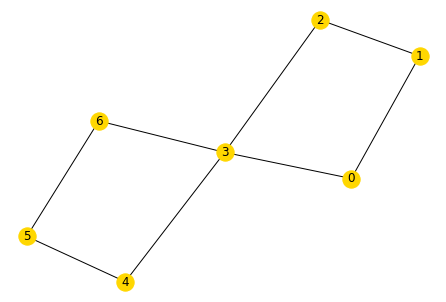

In [8]:
#G = square_graph()
G = bowtie_graph()
nx.draw_spring(G, with_labels=True, node_color='gold')

In [9]:
# Step 1: Jump Start
# Run an efficient classical approximation algorithm to warm-start the optimization
# (For now, we will select the trivial set of bitstrings with Hamming weight equal to 1)
nq = len(G.nodes)
I_cl = []
for i in range(nq):
    bitstr = ['0']*nq
    bitstr[i] = '1'
    I_cl.append(''.join(bitstr))
print(I_cl)

['1000000', '0100000', '0010000', '0001000', '0000100', '0000010', '0000001']


In [10]:
# Step 2: Mixer Initialization
# Select any one of the initial strings and apply two mixing unitaries separated by the phase separator unitary
dqv_circ = QuantumCircuit(nq, name='q')

# Add an ancilla qubit for implementing the mixer unitaries
anc_reg = QuantumRegister(1, 'anc')
dqv_circ.add_register(anc_reg)

init_state = I_cl[0] # for now, select the first initial bitstr
for qb, bit in enumerate(reversed(init_state)):
    if bit == '1':
        dqv_circ.x(qb)
dqv_circ.barrier()

# initial values for the variational parameters
alpha_1 = [1]*nq # hard code angles to 1 for now
gamma_1 = 1
alpha_2 = [1]*nq

apply_mixer(dqv_circ, alpha_1, init_state, G)
dqv_circ.barrier()
apply_phase_separator(dqv_circ, gamma_1, G)
dqv_circ.barrier()
apply_mixer(dqv_circ, alpha_2, init_state, G)

dqv_circ.draw(output='text', fold=180)

░      ┌───────┐                                                                                                     ░                                                »
  q_0: ──────░──────┤ RX(2) ├───────o─────────────o───────────────────────o─────────────o─────────────────────────────────────────░───■─────────────■────■──────────────────────■──»
             ░      └───┬───┘       │  ┌───────┐  │                       │             │                                         ░ ┌─┴─┐┌───────┐┌─┴─┐  │                      │  »
  q_1: ──────░───o──────┼──────o────┼──┤ RX(2) ├──┼────o─────────────o────┼─────────────┼─────────────────────────────────────────░─┤ X ├┤ RZ(2) ├┤ X ├──┼──────■───────────────┼──»
             ░   │      │      │    │  └───┬───┘  │    │  ┌───────┐  │    │             │                                         ░ └───┘└───────┘└───┘  │    ┌─┴─┐  ┌───────┐  │  »
  q_2: ──────░───┼──────┼──────┼────o──────┼──────o────┼──┤ RX(2) ├──┼────o─────────────o─────────────────────────────────────────░──────────────────────┼────┤ X ├──┤ RZ(2) ├──┼──»
             ░   │      │      │    │      │      │    │  └───┬───┘  │    │  ┌───────┐  │                                         ░                    ┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐»
  q_3: ──────░───o──────┼──────o────┼──────┼──────┼────o──────┼──────o────┼──┤ RX(2) ├──┼────o─────────────o──────────────────────░────────────────────┤ X ├┤ RZ(2) ├─────────┤ X ├»
             ░   │      │      │    │      │      │    │      │      │    │  └───┬───┘  │    │  ┌───────┐  │                      ░                    └───┘└───────┘         └───┘»
  q_4: ──────░───┼──────┼──────┼────┼──────┼──────┼────┼──────┼──────┼────o──────┼──────o────┼──┤ RX(2) ├──┼────o─────────────o───░────────────────────────────────────────────────»
             ░   │      │      │    │      │      │    │      │      │    │      │      │    │  └───┬───┘  │    │  ┌───────┐  │   ░                                                »
  q_5: ──────░───┼──────┼──────┼────┼──────┼──────┼────┼──────┼──────┼────┼──────┼──────┼────o──────┼──────o────┼──┤ RX(2) ├──┼───░────────────────────────────────────────────────»
       ┌───┐ ░   │      │      │    │      │      │    │      │      │    │      │      │    │      │      │    │  └───┬───┘  │   ░                                                »
  q_6: ┤ X ├─░───┼──────┼──────┼────┼──────┼──────┼────┼──────┼──────┼────o──────┼──────o────┼──────┼──────┼────o──────┼──────o───░────────────────────────────────────────────────»
       └───┘ ░ ┌─┴─┐    │    ┌─┴─┐┌─┴─┐    │    ┌─┴─┐┌─┴─┐    │    ┌─┴─┐┌─┴─┐    │    ┌─┴─┐┌─┴─┐    │    ┌─┴─┐┌─┴─┐    │    ┌─┴─┐ ░                                                »
anc_0: ──────░─┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├─░────────────────────────────────────────────────»
             ░ └───┘         └───┘└───┘         └───┘└───┘         └───┘└───┘         └───┘└───┘         └───┘└───┘         └───┘ ░                                                »
«                                                                                                       ░      ┌───────┐                                                         »
«  q_0: ────────────────────────────────────────────────────────────────────────────────────────────────░──────┤ RX(2) ├───────o─────────────o───────────────────────o───────────»
«                                                                                                       ░      └───┬───┘       │  ┌───────┐  │                       │           »
«  q_1: ──■─────────────────────────────────────────────────────────────────────────────────────────────░───o──────┼──────o────┼──┤ RX(2) ├──┼────o─────────────o────┼───────────»
«       ┌─┴─┐                                                                                           ░   │      │      │    │  └───┬───┘  │    │  ┌───────┐  │    │           »
«  q_2: ┤ X ├──■─────────────■───────────

## Generate random Erdos-Renyi graphs, partition, and construct corresponding circuits

In [33]:
def view_partition(partition, G):
    node_colors = []
    for node in G.nodes:
        if node in partition[0]:
            node_colors.append('gold')
        else:
            node_colors.append('lightblue')
    
    edge_colors = []
    for edge in G.edges:
        if (edge[0] in partition[0] and edge[1] in partition[1]) or \
           (edge[0] in partition[1] and edge[1] in partition[0]):
            edge_colors.append('red')
        else:
            edge_colors.append('black')
    nx.draw_spring(G, with_labels=True, node_color=node_colors, edge_color=edge_colors)

def get_subgraphs(G, partition):
    subgraphs = []
    cut_edges = []
    all_edges = G.edges
    for subgraph_nodes in partition:
        subG = nx.Graph()
        subG.add_nodes_from(subgraph_nodes)
        
        for v1, v2 in all_edges:
            if v1 in subgraph_nodes and v2 in subgraph_nodes:
                subG.add_edge(v1, v2)
            if v1 in subgraph_nodes and v2 not in subgraph_nodes:
                cut_edges.append((v1, v2))
        
        subgraphs.append(subG)
    
    return subgraphs, cut_edges

def strip_ancillas(counts, circ):
    num_anc = len(circ.ancillas)
    new_counts = {}
    for key in counts:
        new_counts[key[num_anc:]] = counts[key]
    return new_counts

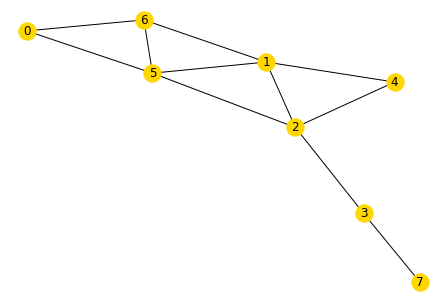

In [119]:
n = 8
p = 0.4
G = nx.erdos_renyi_graph(n, p)
#G = test_graph(n, p)
nx.draw_spring(G, with_labels=True, node_color='gold')

({2, 3, 4, 7}, {0, 1, 5, 6})


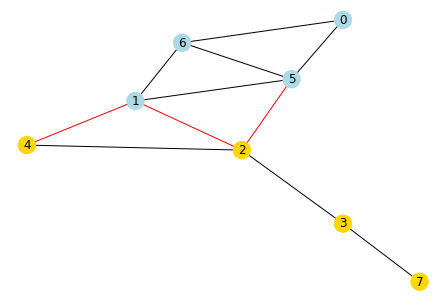

In [120]:
kl_bisection = kernighan_lin_bisection(G)
print(kl_bisection)
view_partition(kl_bisection, G)

[(0, 6), (2, 5)]


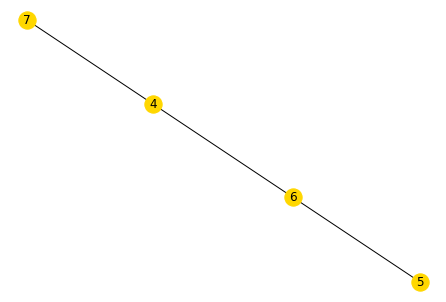

In [11]:
(g1, g2), cutedges = get_subgraphs(G, kl_bisection)
print(cutedges)
nx.draw(g1, with_labels=True, node_color='gold')

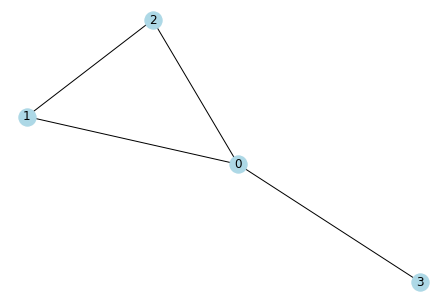

In [12]:
nx.draw(g2, with_labels=True, node_color='lightblue')

In [27]:
def gen_dqva(G, partition, params=[], init_state=None, barriers=1, cut=False,
             decompose_toffoli=1, mixer_order=None, hot_nodes=[]):
    
    nq = len(G.nodes)
    if cut:
        subgraphs, cutedges = get_subgraphs(G, partition)
    else:
        subgraphs = [G]
        cutedges = []
    
    print('Current partition:', partition)
    print('subgraphs:', [list(g.nodes) for g in subgraphs])
    print('cutedges:', cutedges)
    # The hot nodes parameter controls which of the nodes on the cut edges we will
    # hit with a mixer unitary. The other nodes on the cut are "cold" and their
    # mixer will be Identity
    print('hot nodes:', hot_nodes)
    
    # Step 1: Jump Start
    # Run an efficient classical approximation algorithm to warm-start the optimization
    # (For now, we will select the trivial set of bitstrings with Hamming weight equal to 1)
    # Each partition should get its own jump start
    if init_state is None:
        sub_strs = []
        for sg in subgraphs:
            cur_strs = []
            for i in range(len(sg.nodes)):
                bitstr = ['0']*len(sg.nodes)
                bitstr[i] = '1'
                cur_strs.append(''.join(bitstr))
            sub_strs.append(cur_strs)
    
    
        I_cl = []
        for combo in itertools.product(*sub_strs):
            I_cl.append(''.join(combo))
        init_state = I_cl[0] # for now, select the first initial bitstr
    
    # Step 2: Mixer Initialization
    # Select any one of the initial strings and apply two mixing unitaries separated by the phase separator unitary
    dqv_circ = QuantumCircuit(nq, name='q')

    # Add an ancilla qubit, 1 for each subgraph, for implementing the mixer unitaries
    anc_reg = AncillaRegister(len(subgraphs), 'anc')
    dqv_circ.add_register(anc_reg)
    
    #print('Init state:', init_state)
    for qb, bit in enumerate(reversed(init_state)):
        if bit == '1':
            dqv_circ.x(qb)
    if barriers > 0:
        dqv_circ.barrier()

    # parse the variational parameters
    # NOTE: current implementation is hardcoded to p = 1.5
    num_nonzero = nq - hamming_weight(init_state)
    assert (len(params) == 2 * num_nonzero + 1),"Incorrect number of parameters!"
    alpha_1 = params[:num_nonzero]
    gamma_1 = params[num_nonzero:num_nonzero+1][0]
    alpha_2 = params[num_nonzero+1:]

    for anc_idx, subgraph in enumerate(subgraphs):
        apply_mixer(dqv_circ, alpha_1, init_state, subgraph, anc_idx, cutedges,
                    barriers, decompose_toffoli, mixer_order, hot_nodes)
    if barriers > 0:
        dqv_circ.barrier()
    
    for subgraph in subgraphs:
        apply_phase_separator(dqv_circ, gamma_1, subgraph)
    if barriers > 0:
        dqv_circ.barrier()

    for anc_idx, subgraph in enumerate(subgraphs):
        apply_mixer(dqv_circ, alpha_2, init_state, subgraph, anc_idx, cutedges,
                    barriers, decompose_toffoli, mixer_order, hot_nodes)

    if decompose_toffoli > 1:
        #basis_gates = ['x', 'cx', 'barrier', 'crx', 'tdg', 't', 'rz', 'h']
        basis_gates = ['x', 'h', 'cx', 'crx', 'rz', 't', 'tdg', 'u1']
        pass_ = Unroller(basis_gates)
        pm = PassManager(pass_)
        dqv_circ = pm.run(dqv_circ)
    
    return dqv_circ

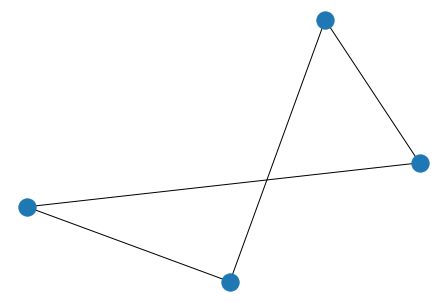

In [16]:
G = ring_graph(4)
nx.draw_spring(G)

In [200]:
init_state = '0001'
numparams = 2 * (len(init_state) - hamming_weight(init_state)) + 1
circ = gen_dqva(G, kl_bisection, params=[i for i in range(1, numparams+1)], init_state=init_state, decompose_toffoli=False)

Initial state: 0001
Subgraphs and cutedges: [<networkx.classes.graph.Graph object at 0x7fb429cd0190>], []
[1, 2, 3, 4, 5, 6, 7]
init state: 0001
alpha: [None, 1, 2, 3]
mixer on qubit 0
Skip!
mixer on qubit 1
param: 1
mixer on qubit 2
param: 2
mixer on qubit 3
param: 3
init state: 0001
alpha: [None, 5, 6, 7]
mixer on qubit 0
Skip!
mixer on qubit 1
param: 5
mixer on qubit 2
param: 6
mixer on qubit 3
param: 7


In [201]:
circ.draw(output='text', fold=180)

┌───┐ ░                                                           ░ ┌───────┐ ░                                                             
  q_0: ┤ X ├─░───o─────────────o───────────────────────o─────────────o───░─┤ RZ(8) ├─░───o──────────────o────────────────────────o──────────────o──
       └───┘ ░   │  ┌───────┐  │                       │             │   ░ ├───────┤ ░   │  ┌────────┐  │                        │              │  
  q_1: ──────░───┼──┤ RX(2) ├──┼────o─────────────o────┼─────────────┼───░─┤ RZ(8) ├─░───┼──┤ RX(10) ├──┼────o──────────────o────┼──────────────┼──
             ░   │  └───┬───┘  │    │  ┌───────┐  │    │             │   ░ ├───────┤ ░   │  └───┬────┘  │    │  ┌────────┐  │    │              │  
  q_2: ──────░───o──────┼──────o────┼──┤ RX(4) ├──┼────o─────────────o───░─┤ RZ(8) ├─░───o──────┼───────o────┼──┤ RX(12) ├──┼────o──────────────o──
             ░   │      │      │    │  └───┬───┘  │    │  ┌───────┐  │   ░ ├───────┤ ░   │      │       │    │  └───┬────┘  │    │  ┌────────┐  │  
  q_3: ──────░───┼──────┼──────┼────o──────┼──────o────┼──┤ RX(6) ├──┼───░─┤ RZ(8) ├─░───┼──────┼───────┼────o──────┼───────o────┼──┤ RX(14) ├──┼──
             ░ ┌─┴─┐    │    ┌─┴─┐┌─┴─┐    │    ┌─┴─┐┌─┴─┐└───┬───┘┌─┴─┐ ░ └───────┘ ░ ┌─┴─┐    │     ┌─┴─┐┌─┴─┐    │     ┌─┴─┐┌─┴─┐└───┬────┘┌─┴─┐
anc_0: ──────░─┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├─░───────────░─┤ X ├────■─────┤ X ├┤ X ├────■─────┤ X ├┤ X ├────■─────┤ X ├
             ░ └───┘         └───┘└───┘         └───┘└───┘         └───┘ ░           ░ └───┘          └───┘└───┘          └───┘└───┘          └───┘

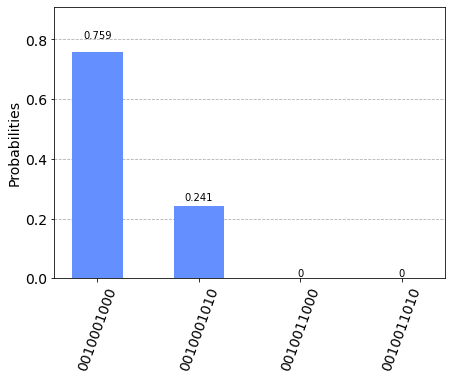

In [16]:
dqv_circ = gen_dqva(G, kl_bisection, params=None, init_state=None)

# Compute the cost function
result = execute(dqv_circ, backend=Aer.get_backend('statevector_simulator')).result()
statevector = Statevector(result.get_statevector(dqv_circ))
counts = statevector.probabilities_dict()
plot_histogram(counts)

In [73]:
cur_init_state = '10000000'
backend = Aer.get_backend('statevector_simulator')
def f(params):
    # Generate a circuit
    dqv_circ = gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state)
    
    # Compute the cost function
    result = execute(dqv_circ, backend=backend).result()
    statevector = Statevector(result.get_statevector(dqv_circ))
    counts = statevector.probabilities_dict()
    
    counts = strip_ancillas(counts, dqv_circ)
    
    avg_cost = 0
    for sample in counts.keys():
        x = [int(bit) for bit in list(sample)]
        # Cost function is Hamming weight
        avg_cost += counts[sample] * sum(x)
    
    # Return the negative of the cost for minimization
    return -avg_cost

In [74]:
out = minimize(f, x0=[0]*17, method='nelder-mead')
opt_params = out['x']
opt_cost = out['fun']
print('Optimal Parameters:', opt_params)
print('Optimal cost:', opt_cost)

Optimal Parameters: [-4.18475618e-01  2.93353691e-01 -5.47655153e-01  5.93670219e-01
  3.94013492e-01  3.02406463e-01 -9.00312383e-01 -2.07405349e-02
 -1.82532182e-05  1.07184002e-01  1.27746411e+00 -3.58859800e-01
  9.77100351e-01  1.11372093e-01 -6.11819632e-01  4.24892863e-01
 -5.99559575e-01]
Optimal cost: -2.9999999984868677


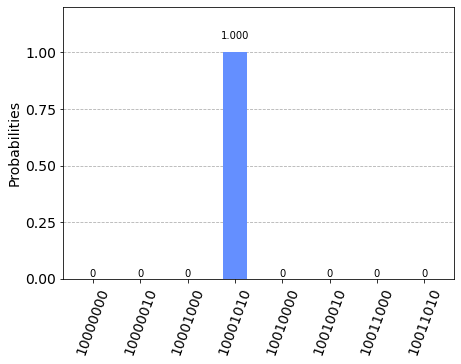

In [75]:
dqv_circ = gen_dqva(G, kl_bisection, params=opt_params, init_state=cur_init_state)

# Compute the cost function
result = execute(dqv_circ, backend=Aer.get_backend('statevector_simulator')).result()
statevector = Statevector(result.get_statevector(dqv_circ))
counts = statevector.probabilities_dict()
counts = strip_ancillas(counts, dqv_circ)
plot_histogram(counts)

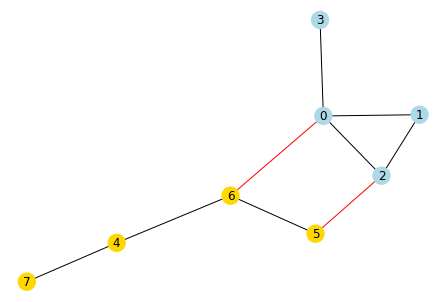

In [77]:
view_partition(kl_bisection, G)

In [34]:
def is_indset(bitstr, G):
    nodes = list(G.nodes)
    ind_set = []
    for idx, bit in enumerate(reversed(bitstr)):
        if bit == '1':
            cur_neighbors = list(G.neighbors(idx))
            for node in ind_set:
                if node in cur_neighbors:
                    return False
            else:
                ind_set.append(idx)
    return True

def hamming_weight(bitstr):
    return sum([1 for bit in bitstr if bit == '1'])

def gen_binary_str(n, bitstr, ret):
    """
    Generate all binary strings of length n
    """
    if n > 0:
        gen_binary_str(n-1, bitstr + '0', ret)
        gen_binary_str(n-1, bitstr + '1', ret)
    else:
        ret.append(bitstr)
    return ret

def brute_force_search(G):
    num_nodes = len((list(G.nodes)))
    bitstrs = gen_binary_str(num_nodes, '', [])
    best_str, best_hamming_weight = '', 0
    for bitstr in bitstrs:
        if is_indset(bitstr, G) and hamming_weight(bitstr) > best_hamming_weight:
            best_str = bitstr
            best_hamming_weight = hamming_weight(bitstr)
    return best_str, best_hamming_weight

In [85]:
# Step 3: Dynamic Ansatz Update
print(counts)
cur_hamming = hamming_weight(cur_init_state)
print(cur_init_state, cur_hamming)
better_strs = []
for bitstr in counts:
    print(bitstr, ':', is_indset(bitstr, G))
    this_hamming = hamming_weight(bitstr)
    if is_indset(bitstr, G) and this_hamming > cur_hamming:
        better_strs.append((bitstr, this_hamming))
better_strs = sorted(better_strs, key=lambda t: t[1], reverse=True)
print(better_strs)
new_str = better_strs[0][0]
print(new_str)

{'10000000': 5.3499938026989e-19, '10000010': 9.499440978489462e-10, '10001000': 5.631907083861356e-10, '10001010': 0.9999999984868662, '10010000': 3.305603285125425e-35, '10010010': 7.985686926893881e-35, '10011000': 9.256147302417654e-35, '10011010': 6.692498392696366e-37}
10000000 1
10000000 : True
10000010 : True
10001000 : True
10001010 : True
10010000 : False
10010010 : False
10011000 : False
10011010 : False
[('10001010', 3), ('10000010', 2), ('10001000', 2)]
10001010


In [41]:
def dynamic_ansatz_update(init_state, G, m=4, threshold=1e-5, cutoff=5, sim='statevector', shots=8192):

    kl_bisection = kernighan_lin_bisection(G)
    backend = Aer.get_backend(sim+'_simulator')
    cur_permutation = list(np.random.permutation(list(G.nodes)))
    
    history = []
    
    def f(params):
        # Generate a circuit
        dqv_circ = gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=False,
                            mixer_order=cur_permutation)

        # Compute the cost function
        if sim == 'statevector':
            result = execute(dqv_circ, backend=backend).result()
            statevector = Statevector(result.get_statevector(dqv_circ))
            probs = strip_ancillas(statevector.probabilities_dict(decimals=5), dqv_circ)
        elif sim == 'qasm':
            dqv_circ.measure_all()
            result = execute(dqv_circ, backend=backend, shots=shots).result()
            counts = strip_ancillas(result.get_counts(dqv_circ), dqv_circ)
            probs = {sample: counts[sample] / shots for sample in counts.keys()}

        avg_cost = 0
        for sample in probs.keys():
            x = [int(bit) for bit in list(sample)]
            # Cost function is Hamming weight
            avg_cost += probs[sample] * sum(x)

        # Return the negative of the cost for minimization
        return -avg_cost
    
    # Step 3: Dynamic Ansatz Update
    # Begin outer optimization loop
    best_indset = init_state
    best_init_state = init_state
    cur_init_state = init_state
    
    # Randomly permute the order of mixer unitaries m times
    for step4_round in range(1, m+1):
        step3_round = 1
        new_hamming_weight = hamming_weight(cur_init_state)
        old_hamming_weight = -1
        
        # Attempt to improve the Hamming weight until no further improvements can be made
        while new_hamming_weight > old_hamming_weight:
            print('Start round {}.{}, Initial state = {}'.format(step4_round, step3_round, cur_init_state))

            # Inner variational loop
            num_params = 2 * (len(cur_init_state) - hamming_weight(cur_init_state)) + 1
            print('\tNum params =', num_params)
            init_params = np.random.uniform(low=0.0, high=2*np.pi, size=num_params)
            print('\tCurrent Mixer Order:', cur_permutation)
            out = minimize(f, x0=init_params, method='COBYLA')
            opt_params = out['x']
            opt_cost = out['fun']
            #print('\tOptimal Parameters:', opt_params)
            print('\tOptimal cost:', opt_cost)

            # Get the results of the optimized circuit
            dqv_circ = gen_dqva(G, kl_bisection, params=opt_params, init_state=cur_init_state,
                                mixer_order=cur_permutation, cut=False)
            result = execute(dqv_circ, backend=Aer.get_backend('statevector_simulator')).result()
            statevector = Statevector(result.get_statevector(dqv_circ))
            counts = strip_ancillas(statevector.probabilities_dict(decimals=5), dqv_circ)

            # Select the top [cutoff] counts
            top_counts = sorted([(key, counts[key]) for key in counts if counts[key] > threshold],
                                key=lambda tup: tup[1], reverse=True)[:cutoff]
            # Check if we have improved the Hamming weight
            old_hamming_weight = hamming_weight(cur_init_state)
            better_strs = []
            for bitstr, prob in top_counts:
                this_hamming = hamming_weight(bitstr)
                if is_indset(bitstr, G) and this_hamming > old_hamming_weight:
                    better_strs.append((bitstr, this_hamming))
            better_strs = sorted(better_strs, key=lambda t: t[1], reverse=True)
            prev_init_state = cur_init_state
            
            # Save current results to history
            temp_history = {'round':'{}.{}'.format(step4_round, step3_round),
                            'cost':opt_cost, 'permutation':cur_permutation, 'topcounts':top_counts,
                            'previnit':prev_init_state}
            
            # If no improvement was made, break and go to next step4 round
            if len(better_strs) == 0:
                print('\tNone of the measured bitstrings had higher Hamming weight than:', prev_init_state)
                history.append(temp_history)
                break
            
            # Otherwise, save the new bitstring and check if it is better than all we have seen thus far
            cur_init_state, new_hamming_weight = better_strs[0]
            if new_hamming_weight > hamming_weight(best_indset):
                best_indset = cur_init_state
                best_init_state = prev_init_state
            print('\tFound new independent set: {}, Hamming weight = {}'.format(cur_init_state, new_hamming_weight))
            temp_history['curinit'] = cur_init_state
            history.append(temp_history)
            step3_round += 1
        
        # Choose a new permutation of the mixer unitaries that have NOT been set to identity
        identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '1']
        non_identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '0']
        permutation = np.random.permutation(non_identity_mixers)
        perm_queue = queue.Queue()
        for p in permutation:
            perm_queue.put(p)
        for i, mixer in enumerate(cur_permutation):
            if mixer in identity_mixers:
                continue
            else:
                cur_permutation[i] = perm_queue.get()
    
    print('\tRETURNING, best hamming weight:', new_hamming_weight)
    return best_indset, opt_params, best_init_state, kl_bisection, history

[(1, 2), (1, 9), (1, 10), (2, 5), (2, 4), (5, 9), (5, 0), (9, 8), (4, 7), (4, 11), (7, 6), (7, 8), (10, 11), (10, 3), (11, 8), (6, 0), (6, 3), (3, 0)]


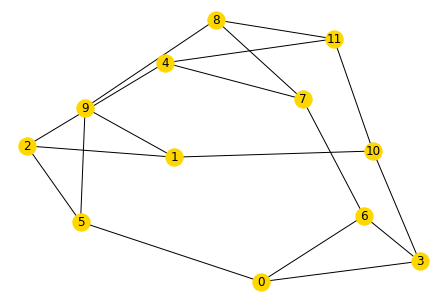

In [84]:
G = nx.random_regular_graph(3,12)
print(list(G.edges()))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [85]:
ind_sets = []
all_histories = []
end_times = []
start_time = time.time()
#for i in range(len(G.nodes)):
for i in range(3):
    init_state = ['0']*len(G.nodes)
    #init_state[i] = '1'
    init_state = ''.join(init_state)
    output = dynamic_ansatz_update(init_state, G, m=4, sim='qasm')
    ind_sets.append(output[0])
    all_histories.append((init_state, output))
    print('Best independent set:', output[0],'\n')
    end_times.append(time.time())

Start round 1.1, Initial state = 000000000000
	Num params = 25
	Current Mixer Order: [5, 8, 2, 4, 3, 1, 10, 9, 6, 0, 11, 7]
	Optimal cost: -4.9896240234375
	Found new independent set: 010101110000, Hamming weight = 5
Start round 1.2, Initial state = 010101110000
	Num params = 15
	Current Mixer Order: [5, 8, 2, 4, 3, 1, 10, 9, 6, 0, 11, 7]
	Optimal cost: -5.0
	None of the measured bitstrings had higher Hamming weight than: 010101110000
Start round 2.1, Initial state = 010101110000
	Num params = 15
	Current Mixer Order: [5, 8, 7, 4, 9, 3, 10, 0, 6, 11, 1, 2]
	Optimal cost: -5.0
	None of the measured bitstrings had higher Hamming weight than: 010101110000
Start round 3.1, Initial state = 010101110000
	Num params = 15
	Current Mixer Order: [5, 8, 1, 4, 0, 11, 10, 7, 6, 9, 2, 3]
	Optimal cost: -5.0
	None of the measured bitstrings had higher Hamming weight than: 010101110000
Start round 4.1, Initial state = 010101110000
	Num params = 15
	Current Mixer Order: [5, 8, 9, 4, 3, 7, 10, 2, 6, 1, 

True 010101110000 5
True 011010000101 5
True 000100111010 5


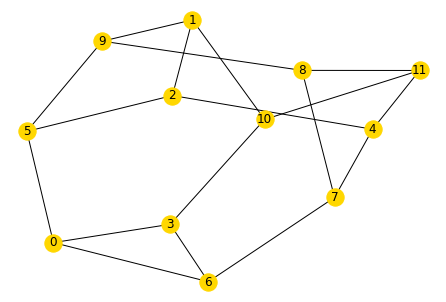

In [86]:
for bitstr in ind_sets:
    print(is_indset(bitstr, G), bitstr, hamming_weight(bitstr))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [92]:
for i, endtime in enumerate(end_times):
    print('Round {} finished at {:.3f}s and found Hamming weight = {}'.format(i+1, endtime-start_time,
                                                                              hamming_weight(ind_sets[i])))

print()
brute_start = time.time()
opt_str, opt_hw = brute_force_search(G)
brute_end = time.time()
print('Brute force search found optimal Hamming weight = {} in {:.3f}s'.format(opt_hw, brute_end-brute_start))

Round 1 finished at 96.612s and found Hamming weight = 5
Round 2 finished at 198.992s and found Hamming weight = 5
Round 3 finished at 282.243s and found Hamming weight = 5

Brute force search found optimal Hamming weight = 5 in 0.031s


In [47]:
# Networkx approximation uses Boppana-Halldorsson
independent_set.maximum_independent_set(G)

{0, 1, 4, 5, 11}

All Histories: 
> [(init_state1, output1), ... , (init_stateN, outputN)]

Output: 
>best_indset, opt_params, best_init_state, kl_bisection, history

History:
> round: {step4_round}.{step3_round},
>
> cost: opt_cost, 
>
> permutation: cur_permutation,
>
> topcounts: top_counts,
>
> previnit: prev_init_state,
>
> curinit: cur_init_state

In [11]:
def plot_dqva_cost_separate(history):
    init_state, output = history
    cur_history = output[4]
        
    costs = [rnd['cost'] for rnd in cur_history]
    rounds = [rnd['round'] for rnd in cur_history]
    xlocs = list(np.arange(1, len(cur_history)+1))
    
    fig, ax = plt.subplots(dpi=150, figsize=[6,3])
    ax.plot(xlocs, costs, label=init_state)
    ax.scatter(xlocs, costs)
    
    ax.set_xticks(xlocs)
    ax.set_xticklabels(rounds)
    
    ax.set_title(r'$c_i = {}$, Final output: {}'.format(init_state, output[0]))
    ax.set_ylabel('Cost (-Hamming weight)')
    ax.set_xlabel('Round')
    ax.legend()
    plt.show()
    plt.close()

def plot_dqva_cost_together(histories):
    # Only works for m < 10
    # Getting the proper x tick locations
    m_rounds = list(set([int(rnd['round'][0]) for rnd in histories[0][1][4]]))
    max_sub_rounds = list(np.zeros(len(m_rounds)))
    for history in histories:
        cur_history = history[1][4]
        for i, m in enumerate(m_rounds):
            num_rounds = len([rnd['round'] for rnd in cur_history if rnd['round'][0] == str(m)])
            if num_rounds > max_sub_rounds[i]:
                max_sub_rounds[i] = int(num_rounds)
    
    xvals = {}
    for m, n in zip(m_rounds, max_sub_rounds):
        xrange = np.linspace(m, m+1, num=n+1)
        for i in range(n):
            xvals['{}.{}'.format(m, i+1)] = xrange[i]
    
    fig, ax = plt.subplots(dpi=150, figsize=[6,3])
    
    for history in histories:
        init_state, output = history
        cur_history = output[4]

        costs = [rnd['cost'] for rnd in cur_history]
        rounds = [rnd['round'] for rnd in cur_history]
        xlocs = [xvals[rnd] for rnd in rounds]

        ax.plot(xlocs, costs, label=init_state, lw=1)
        ax.scatter(xlocs, costs, s=10)

    ax.set_xticks([xvals[key] for key in xvals.keys()])
    ax.set_xticklabels([key for key in xvals.keys()])
    
    ax.set_title('All initial states')
    ax.set_ylabel('Cost (-Hamming weight)')
    ax.set_xlabel('Round')
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='xx-small')
    plt.show()
    plt.close()

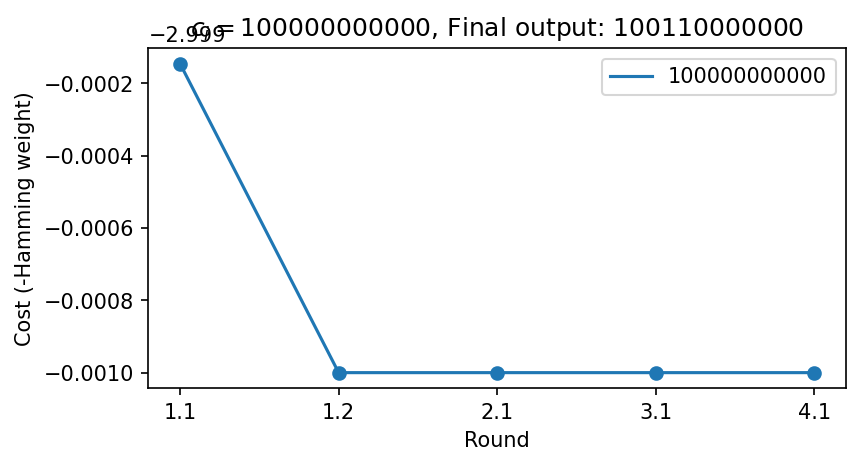

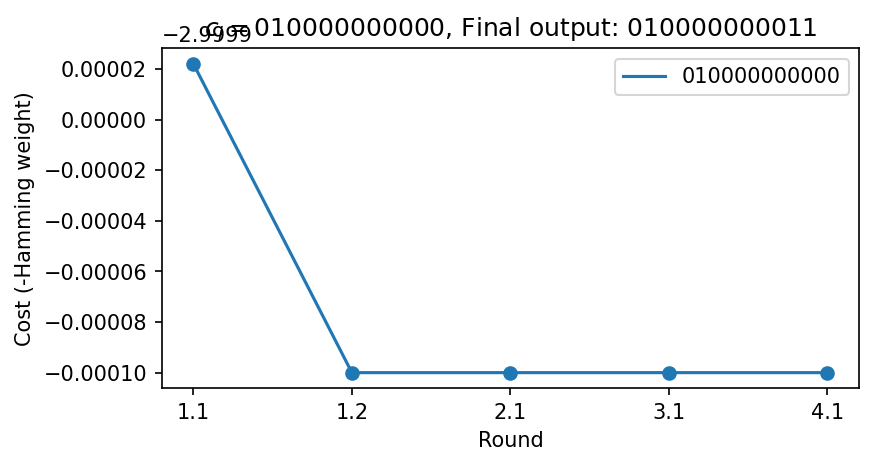

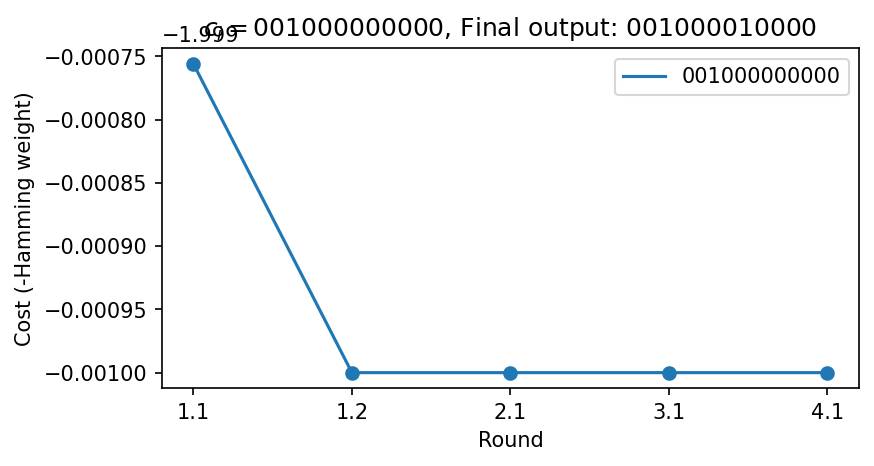

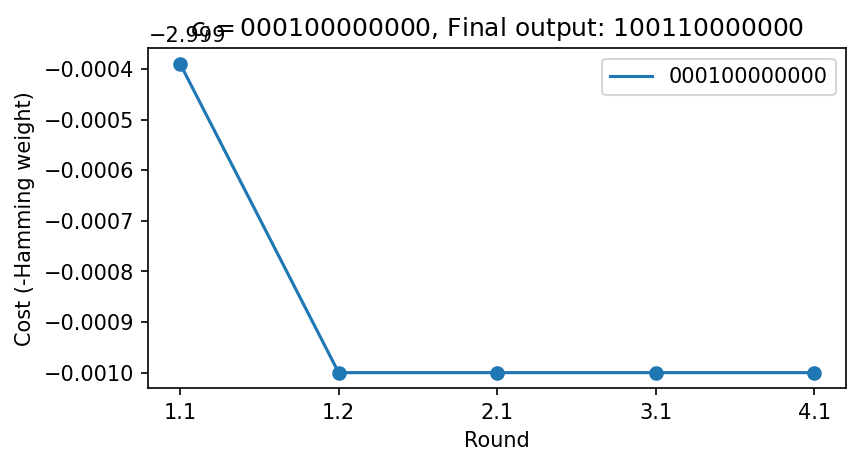

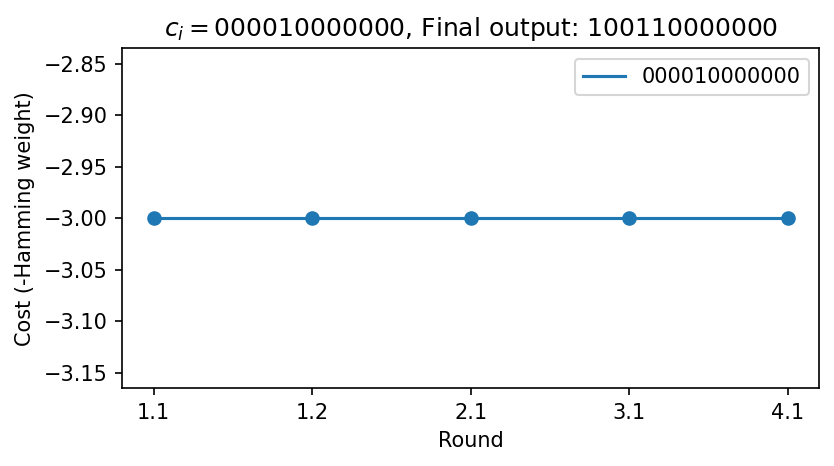

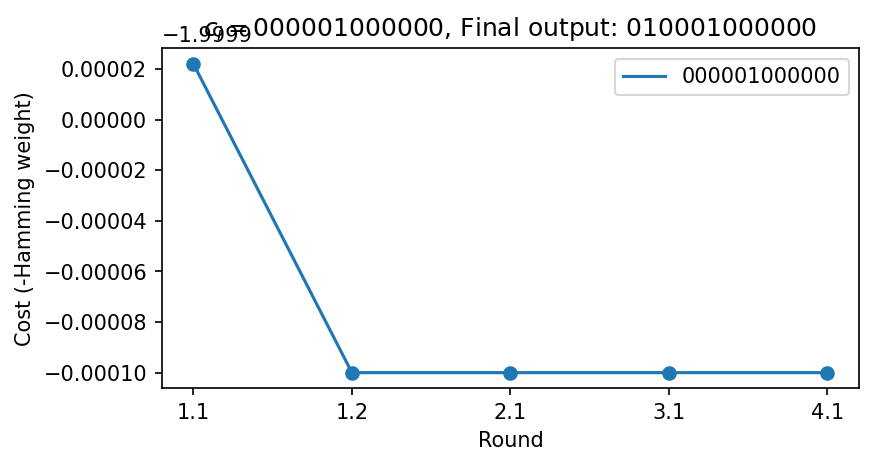

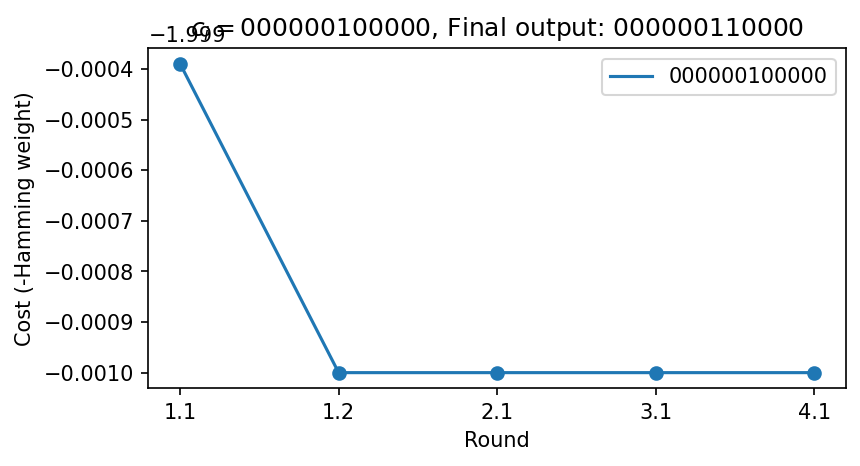

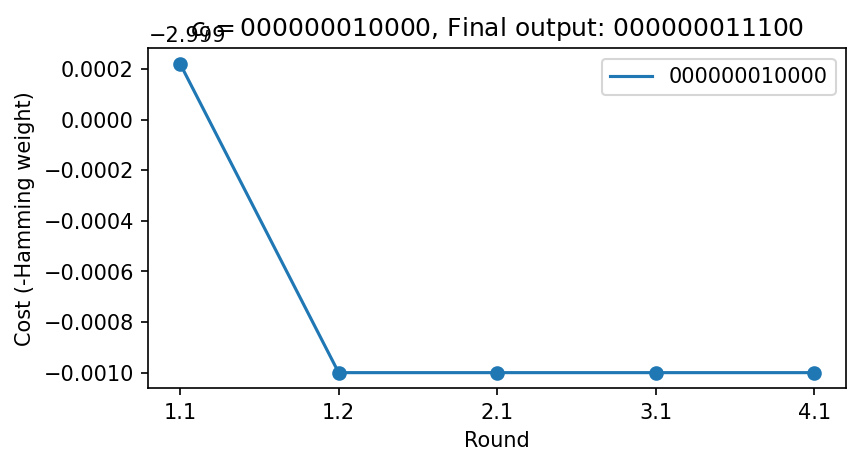

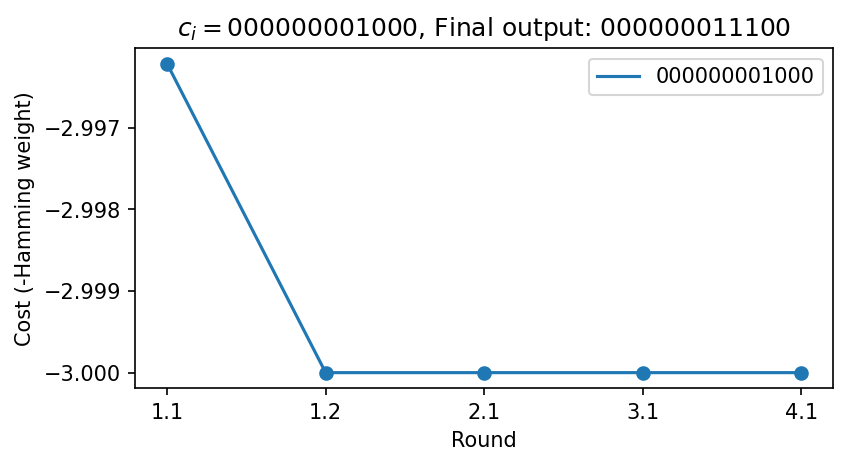

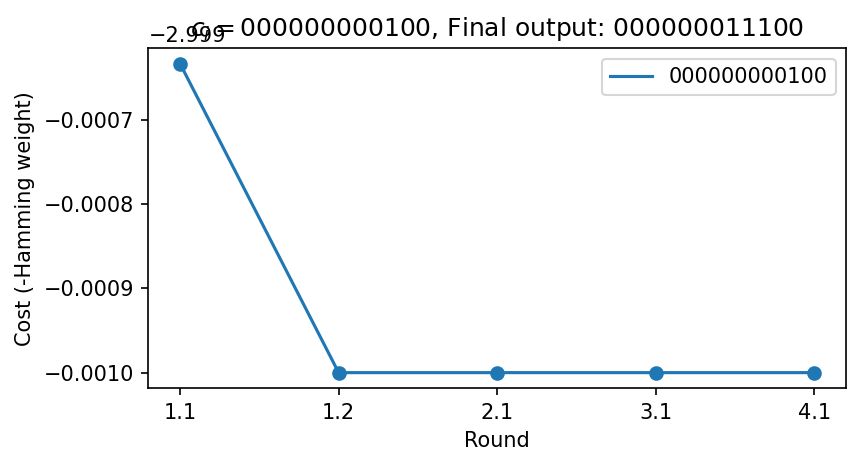

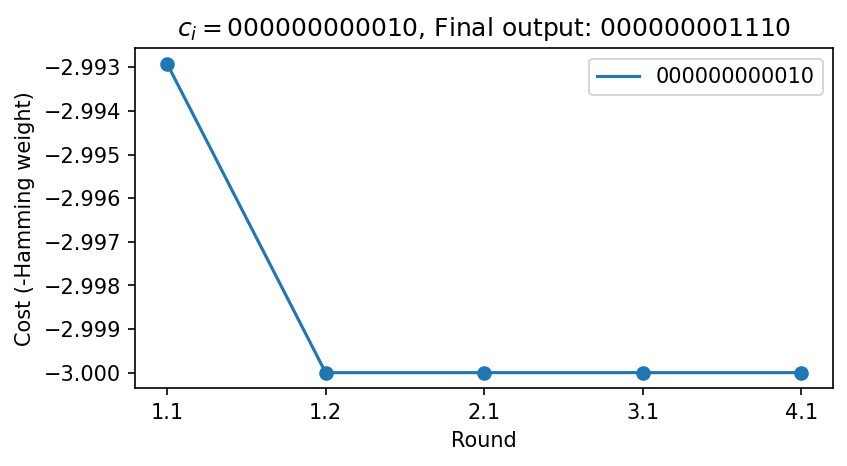

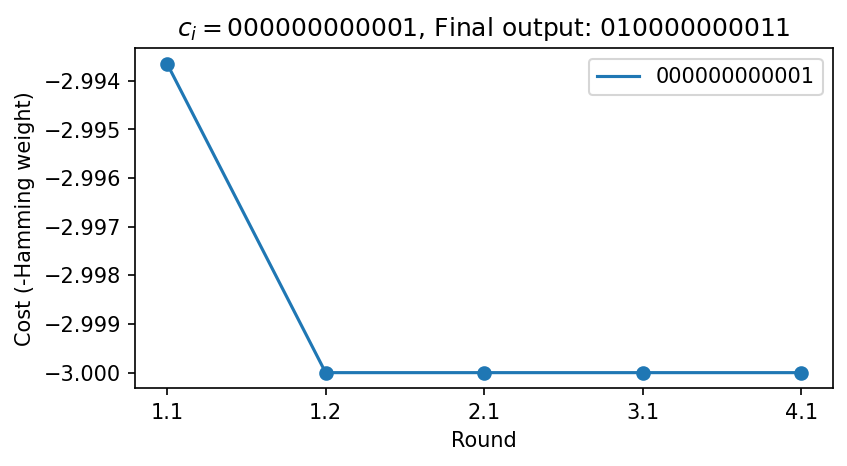

In [302]:
for history in all_histories:
    plot_dqva_cost_separate(history)

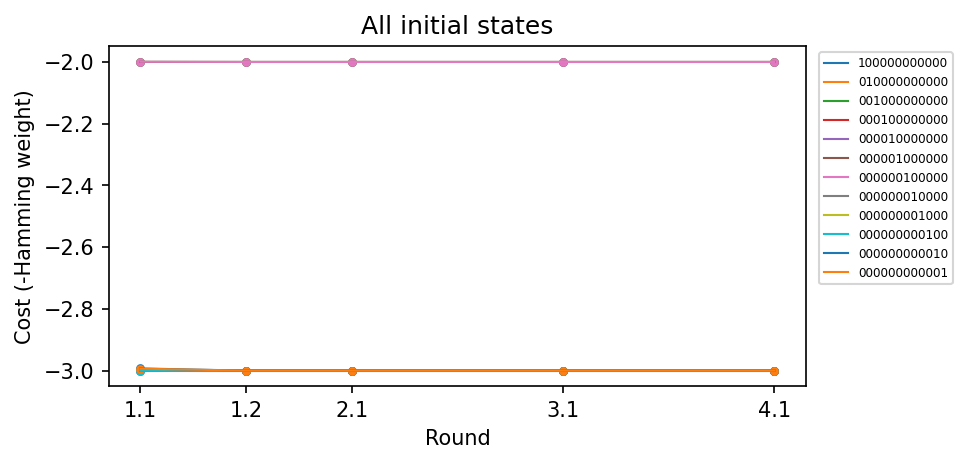

In [303]:
plot_dqva_cost_together(all_histories)

In [12]:
def plot_state_hist(probs, savestr=None):
    fig, ax = plt.subplots(dpi=150)
    x, y, ticks = [], [], []
    for i, bitstr in enumerate(probs.keys()):
        x.append(i)
        y.append(probs[bitstr])
        ticks.append(bitstr)

    prob_rects = ax.bar(x, y, tick_label=ticks)
    ax.set_ylabel('Probabilities')
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '{:.3f}'.format(height),
                    ha='center', va='bottom', fontsize=8)

    autolabel(prob_rects)
    
    plt.xticks(rotation=45)
    ylim = ax.get_ylim()
    ax.set_ylim([ylim[0], ylim[1]*1.05])
    if savestr is not None:
        plt.savefig(savestr)
    plt.show()
    plt.close()

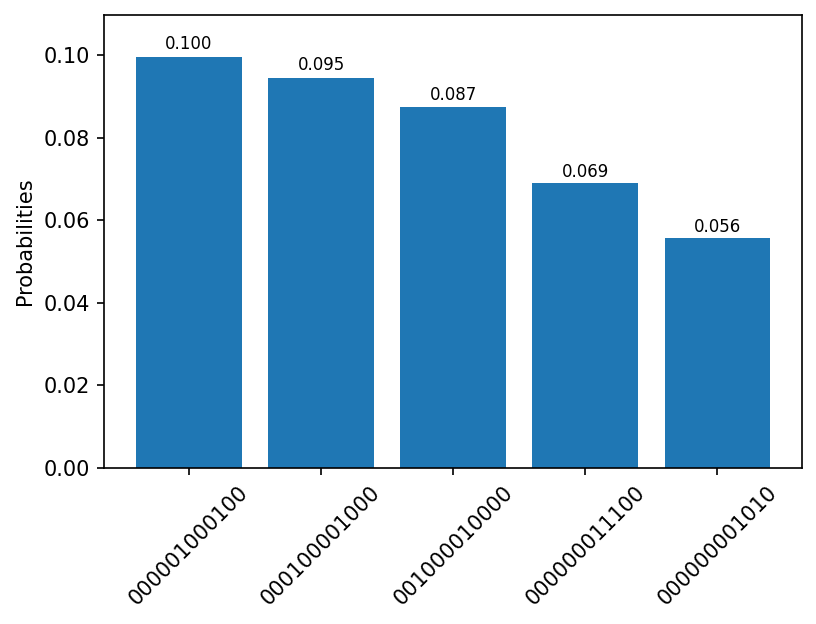

In [305]:
ruslan_result = [('000001000100', 498), ('000100001000', 473), ('001000010000', 437), ('000000011100', 345), ('000000001010', 278)]
total_shots = 5000
plot_state_hist({tup[0]:tup[1]/total_shots for tup in ruslan_result})

### Brute force search of MIS for 3-regular graphs

In [104]:
times = []
nodes = np.arange(6, 28, 2)
for degree in [3,4,5]:
    temp_times = []
    for n in nodes:
        G = nx.random_regular_graph(degree, n)
        start = time.time()
        brute_force_search(G)
        end = time.time()
        print('Regular({}, {}) graph took {:.3f}s'.format(degree, n, end-start))
        temp_times.append(end - start)
    times.append(temp_times)

Regular(3, 6) graph took 0.001s
Regular(3, 8) graph took 0.002s
Regular(3, 10) graph took 0.009s
Regular(3, 12) graph took 0.020s
Regular(3, 14) graph took 0.055s
Regular(3, 16) graph took 0.222s
Regular(3, 18) graph took 0.831s
Regular(3, 20) graph took 3.710s
Regular(3, 22) graph took 15.966s
Regular(3, 24) graph took 58.348s
Regular(3, 26) graph took 291.789s
Regular(4, 6) graph took 0.000s
Regular(4, 8) graph took 0.001s
Regular(4, 10) graph took 0.003s
Regular(4, 12) graph took 0.013s
Regular(4, 14) graph took 0.052s
Regular(4, 16) graph took 0.216s
Regular(4, 18) graph took 0.847s
Regular(4, 20) graph took 3.473s
Regular(4, 22) graph took 15.521s
Regular(4, 24) graph took 53.512s
Regular(4, 26) graph took 280.515s
Regular(5, 6) graph took 0.000s
Regular(5, 8) graph took 0.001s
Regular(5, 10) graph took 0.003s
Regular(5, 12) graph took 0.014s
Regular(5, 14) graph took 0.053s
Regular(5, 16) graph took 0.234s
Regular(5, 18) graph took 0.931s
Regular(5, 20) graph took 3.184s
Regular(

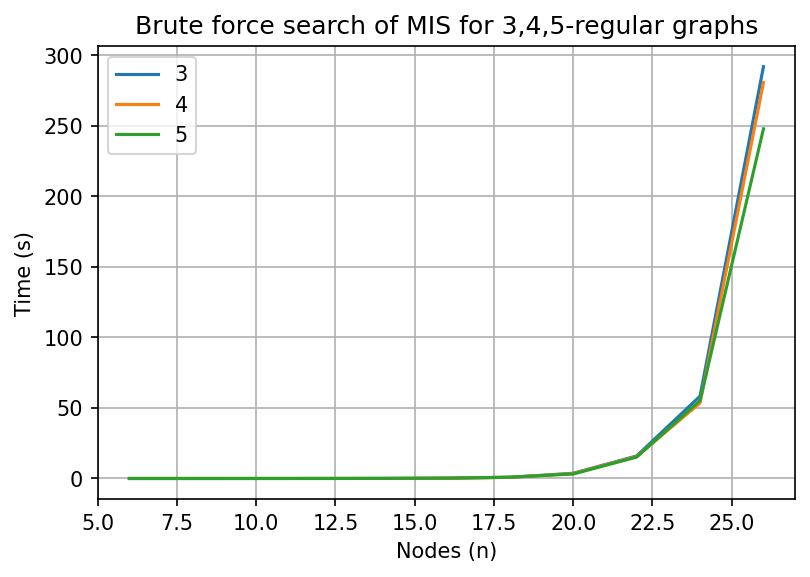

In [106]:
fig, ax = plt.subplots(dpi=150)
labels = [3,4,5]
for time, label in zip(times, labels):
    ax.plot(nodes, time, label=label)
ax.set_ylabel('Time (s)')
ax.set_xlabel('Nodes (n)')
ax.set_title('Brute force search of MIS for 3,4,5-regular graphs')
ax.grid()
ax.legend()

## Circuit cutting + DQVA

In [74]:
def sim_with_cutting(circ, backend, sim, shots):
    circuits = {'dqva_circuit':circ}
    max_subcircuit_qubit = 8
    cutqc = CutQC(circuits=circuits, max_subcircuit_qubit=max_subcircuit_qubit, num_subcircuits=[2], max_cuts=3)
    subcircs = get_subcircs(cutqc, max_subcircuit_qubit)
    print('Complete Path Map:')
    for key in subcircs['complete_path_map']:
        print(key, '->', subcircs['complete_path_map'][key])
    print('positions:', subcircs['positions'])
    for i, sc in enumerate(subcircs['subcircuits']):
        print('Subcirc', i)
        print('\tqubits = {}, gate counts = {}'.format(len(sc.qubits), sc.count_ops()))
        #print(sc.draw(fold=200))
    
    #if sim == 'statevector':
    #    result = execute(dqv_circ, backend=backend).result()
    #    statevector = Statevector(result.get_statevector(dqv_circ))
    #    probs = strip_ancillas(statevector.probabilities_dict(decimals=5), dqv_circ)
    #elif sim == 'qasm':
    #    dqv_circ.measure_all()
    #    result = execute(dqv_circ, backend=backend, shots=shots).result()
    #    counts = strip_ancillas(result.get_counts(dqv_circ), dqv_circ)
    #    probs = {sample: counts[sample] / shots for sample in counts.keys()}
    return

In [75]:
backend = Aer.get_backend('qasm_simulator')
probs = sim_with_cutting(dqv_circ, backend, 'qasm', 8192)

-------------------- Cut --------------------
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
dqva_circuit : 3 cuts --> {0: {'effective': 5, 'rho': 1, 'O': 2, 'd': 7}, 1: {'effective': 5, 'rho': 2, 'O': 1, 'd': 6}}
Complete Path Map:
Qubit(QuantumRegister(8, 'q'), 0) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(7, 'q'), 0)}]
Qubit(QuantumRegister(8, 'q'), 1) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(7, 'q'), 1)}]
Qubit(QuantumRegister(8, 'q'), 2) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(7, 'q'), 2)}]
Qubit(QuantumRegister(8, 'q'), 3) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(7, 'q'), 3)}]
Qubit(QuantumRegister(8, 'q'), 4) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(7, 'q'), 4)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 0)}, {'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(7

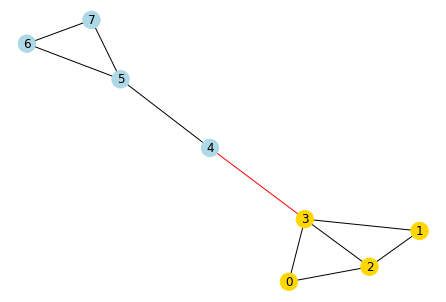

In [31]:
kl_bisection = kernighan_lin_bisection(G)
view_partition(kl_bisection, G)

In [60]:
cur_init_state = '0'*len(G.nodes)
num_params = 2 * (len(cur_init_state) - hamming_weight(cur_init_state)) + 1
cur_permutation = list(G.nodes)
dqv_circ = gen_dqva(G, kl_bisection, params=[1]*num_params, init_state=cur_init_state, cut=True,
                    mixer_order=cur_permutation, decompose_toffoli=2, barriers=0,
                    hot_nodes=[3])
print(dqv_circ.count_ops())
dqv_circ.draw(fold=-1)

Current partition: ({0, 1, 2, 3}, {4, 5, 6, 7})
subgraphs: [[0, 1, 2, 3], [4, 5, 6, 7]]
cutedges: [(3, 4)]
hot nodes: [3]
Neighbors before: [0, 1, 2]
Neighbors after: [0, 1, 2, 4]
Qubit 4 is cold! Apply Identity mixer
Neighbors before: [0, 1, 2]
Neighbors after: [0, 1, 2, 4]
Qubit 4 is cold! Apply Identity mixer
OrderedDict([('cx', 432), ('u1', 348), ('x', 144), ('t', 64), ('h', 56), ('tdg', 48), ('crx', 14), ('rz', 8)])


┌───────┐  ┌───┐                                                                                                                                                                                                                                                                                                                                                                              ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                                    ┌───┐   ┌───┐                                                                                                                                ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌───┐                                                                                                                                                                                                                                                                                                                            ┌───┐    ┌───────────┐                          ┌───┐    ┌──────────┐                          ┌───┐    ┌───────────┐                          ┌───┐    ┌──────────┐                          ┌───┐    ┌───────────┐                          ┌───┐    ┌──────────┐                          ┌───┐    ┌───────────┐                          ┌───┐    ┌──────────┐                                      ┌───┐    ┌───┐                                                                                                                                                                                                                                                                                                                                         ┌───┐    ┌───────────┐                          ┌───┐    ┌──────────┐                          ┌───┐    ┌───────────┐                          ┌───┐    ┌──────────┐                          ┌───┐    ┌───────────┐                          ┌───┐    ┌──────────┐                          ┌───┐    ┌───────────┐                               ┌───┐    ┌──────────┐                               ┌───┐    ┌───────┐                                                                                                                                 ┌───────┐┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌───┐┌──────────┐                                             ┌───┐    ┌─────────┐                             ┌───┐┌──────────┐                                    ┌───┐    ┌─────────┐                                        ┌───┐   ┌───┐                                                                                                                                                                        ┌───┐   ┌──────────┐                                         ┌───┐    ┌─────────┐                                    ┌───┐   ┌──────────┐                                    ┌───┐    ┌─────────┐                         ┌───┐   ┌───┐                                                                                                                                                                                                                                                                                                   

In [23]:
def cut_dqva(init_state, G, m=4, threshold=1e-5, cutoff=5, sim='statevector', shots=8192):

    kl_bisection = kernighan_lin_bisection(G)
    
    
    
    backend = Aer.get_backend(sim+'_simulator')
    cur_permutation = list(np.random.permutation(list(G.nodes)))
    
    history = []
    
    def f(params):
        # Generate a circuit
        # Circuit cutting is not required here, but the circuit should be generated using
        # as much info about the cutting as possible
        dqv_circ = gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=True,
                            mixer_order=cur_permutation)

        # Compute the cost function
        # Circuit cutting will need to be used to perform the execution
        probs = sim_with_cutting(dvq_circ, backend, sim, shots)

        avg_cost = 0
        for sample in probs.keys():
            x = [int(bit) for bit in list(sample)]
            # Cost function is Hamming weight
            avg_cost += probs[sample] * sum(x)

        # Return the negative of the cost for minimization
        return -avg_cost
    
    # Step 3: Dynamic Ansatz Update
    # Begin outer optimization loop
    best_indset = init_state
    best_init_state = init_state
    cur_init_state = init_state
    
    # Randomly permute the order of mixer unitaries m times
    for step4_round in range(1, m+1):
        step3_round = 1
        new_hamming_weight = hamming_weight(cur_init_state)
        old_hamming_weight = -1
        
        # Attempt to improve the Hamming weight until no further improvements can be made
        while new_hamming_weight > old_hamming_weight:
            print('Start round {}.{}, Initial state = {}'.format(step4_round, step3_round, cur_init_state))

            # Inner variational loop
            num_params = 2 * (len(cur_init_state) - hamming_weight(cur_init_state)) + 1
            print('\tNum params =', num_params)
            init_params = np.random.uniform(low=0.0, high=2*np.pi, size=num_params)
            print('\tCurrent Mixer Order:', cur_permutation)
            out = minimize(f, x0=init_params, method='COBYLA')
            opt_params = out['x']
            opt_cost = out['fun']
            #print('\tOptimal Parameters:', opt_params)
            print('\tOptimal cost:', opt_cost)

            # Get the results of the optimized circuit
            dqv_circ = gen_dqva(G, kl_bisection, params=opt_params, init_state=cur_init_state,
                                mixer_order=cur_permutation, cut=False)
            #result = execute(dqv_circ, backend=Aer.get_backend('statevector_simulator')).result()
            #statevector = Statevector(result.get_statevector(dqv_circ))
            #counts = strip_ancillas(statevector.probabilities_dict(decimals=5), dqv_circ)
            counts = sim_with_cutting(dqv_circ, backend, sim, shots)
            
            # Select the top [cutoff] counts
            top_counts = sorted([(key, counts[key]) for key in counts if counts[key] > threshold],
                                key=lambda tup: tup[1], reverse=True)[:cutoff]
            # Check if we have improved the Hamming weight
            old_hamming_weight = hamming_weight(cur_init_state)
            better_strs = []
            for bitstr, prob in top_counts:
                this_hamming = hamming_weight(bitstr)
                if is_indset(bitstr, G) and this_hamming > old_hamming_weight:
                    better_strs.append((bitstr, this_hamming))
            better_strs = sorted(better_strs, key=lambda t: t[1], reverse=True)
            prev_init_state = cur_init_state
            
            # Save current results to history
            temp_history = {'round':'{}.{}'.format(step4_round, step3_round),
                            'cost':opt_cost, 'permutation':cur_permutation, 'topcounts':top_counts,
                            'previnit':prev_init_state}
            
            # If no improvement was made, break and go to next step4 round
            if len(better_strs) == 0:
                print('\tNone of the measured bitstrings had higher Hamming weight than:', prev_init_state)
                history.append(temp_history)
                break
            
            # Otherwise, save the new bitstring and check if it is better than all we have seen thus far
            cur_init_state, new_hamming_weight = better_strs[0]
            if new_hamming_weight > hamming_weight(best_indset):
                best_indset = cur_init_state
                best_init_state = prev_init_state
            print('\tFound new independent set: {}, Hamming weight = {}'.format(cur_init_state, new_hamming_weight))
            temp_history['curinit'] = cur_init_state
            history.append(temp_history)
            step3_round += 1
        
        # Choose a new permutation of the mixer unitaries that have NOT been set to identity
        identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '1']
        non_identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '0']
        permutation = np.random.permutation(non_identity_mixers)
        perm_queue = queue.Queue()
        for p in permutation:
            perm_queue.put(p)
        for i, mixer in enumerate(cur_permutation):
            if mixer in identity_mixers:
                continue
            else:
                cur_permutation[i] = perm_queue.get()
    
    print('\tRETURNING, best hamming weight:', new_hamming_weight)
    return best_indset, opt_params, best_init_state, kl_bisection, history

[(0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (5, 6), (5, 7), (6, 7)]


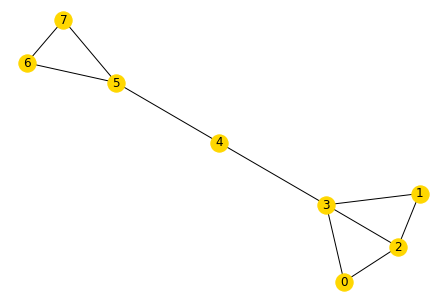

In [30]:
G = test_graph(4, 0.7)
print(list(G.edges()))
nx.draw_spring(G, with_labels=True, node_color='gold')

SystemExit: 

/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


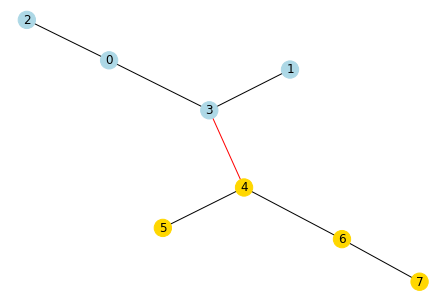

In [37]:
ind_sets = []
all_histories = []
end_times = []
start_time = time.time()
#for i in range(len(G.nodes)):
for i in range(1):
    init_state = ['0']*len(G.nodes)
    #init_state[i] = '1'
    init_state = ''.join(init_state)
    output = cut_dqva(init_state, G, m=4, sim='qasm')
    ind_sets.append(output[0])
    all_histories.append((init_state, output))
    print('Best independent set:', output[0],'\n')
    end_times.append(time.time())